In [10]:
import tensorflow as tf
import keras
import sys
import os
sys.path.append('/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages')
import numpy as np
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout, Flatten, Reshape ,Lambda
from keras.layers import Conv2D, MaxPooling2D , AveragePooling2D
from keras.optimizers import SGD
import configure as cfg

In [11]:
class MnistLoader(object):
    def __init__(self):
        self.img_size = 28
        self.num_channels = 1
        # download MNIST data
        from tensorflow.examples.tutorials.mnist import input_data
        mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

        self.train_imgs = mnist.train.images
        self.train_labs = mnist.train.labels
        self.test_imgs = mnist.test.images
        self.test_labs = mnist.test.labels
        self.val_imgs = mnist.validation.images
        self.val_labs = mnist.validation.labels

        self.train_imgs, self.test_imgs, self.val_imgs = map(lambda imgs: imgs.reshape([-1, 28, 28, 1]),
                                                             [self.train_imgs, self.test_imgs, self.val_imgs])

In [14]:
"""
usage : 
>>> model = Models()
>>> model.simple_model()
>>> model.train()
"""

class Model():
    def __init__(self):
        self.model = Sequential()

    def simple_model(self):
        # Train input shape : (None,32,32,3)
        # Eval input shape : (None , None , None ,3)
        
        # Block 1
        self.model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, cfg.img_ch)))
        self.model.add(Conv2D(32, (3, 3), activation='relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Dropout(0.25))
        # Block 2
        self.model.add(Conv2D(64, (3, 3), activation='relu'))
        self.model.add(Conv2D(64, (3, 3), activation='relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Dropout(0.25))
        # Block 3
        self.model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
        self.model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
        self.model.add(Dropout(0.25))
        # Logits

        self.model.add(Flatten())
        self.model.add(Dense(256, activation='relu'))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(10, activation='softmax'))
        # Optimizer
        sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
        self.model.compile(loss='categorical_crossentropy', optimizer=sgd , metrics=['mse' ,'accuracy'])

    def train(self, x_train, y_train , epochs , batch_size = 30):
        # ref : https://keras.io/callbacks/
        tb_callback = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True,
                                    write_grads=False, write_images=False, embeddings_freq=0,
                                    embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None)

        self.model.fit(x_train, y_train, batch_size = batch_size, epochs=epochs, verbose=1, callbacks=[tb_callback])
        model_dir = self.generate_dir('./models')
        model_path = os.path.join(model_dir, 'model.h5')
        print('Model was saved : {}'.format(model_path))
        self.model.save(model_path)  # creates a HDF5 file 'my_model.h5'

    def eval(self , x_test , y_test ,show):
        loss , mse , acc = self.model.evaluate(x_test, y_test, batch_size=32)
        if show:
            print ("\n loss : {}\t mse : {}\t accuracy : {}\n".format(loss , mse , acc))

        return loss , mse , acc

    def pred(self ,x_test , model_path):
        self.model = load_model(model_path)
        return self.model.predict(x_test, batch_size=None, verbose=0, steps=None)


    def generate_dir(self , root_dir , max_num_folder=1000):
        """
        모델 path 가 겹치지 않게 숫자를 하나씩 올려가며 폴더를 생성합니다
        root_dir/0 , root_dir/1 ..
        :return: dirpath
        """
        for i in range(max_num_folder):
            dirpath=os.path.join(root_dir , str(i))
            if not os.path.isdir(dirpath):
                os.makedirs(dirpath)
                return dirpath

In [15]:
ML = MnistLoader()
model = Model()
model.simple_model()
model.train(ML.train_imgs, ML.train_labs, 10)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Epoch 1/10
55000/55000 [==============================] - 36s 652us/step - loss: 1.0975 - mean_squared_error: 0.0458 - acc: 0.6158
Epoch 2/10
55000/55000 [==============================] - 17s 308us/step - loss: 0.2215 - mean_squared_error: 0.0104 - acc: 0.9317
Epoch 3/10
55000/55000 [==============================] - 17s 305us/step - loss: 0.1477 - mean_squared_error: 0.0070 - acc: 0.9544
Epoch 4/10
55000/55000 [==============================] - 17s 307us/step - loss: 0.1156 - mean_squared_error: 0.0054 - acc: 0.9644
Epoch 5/10
55000/55000 [==============================] - 17s 306us/step - loss: 0.1007 - mean_squared_error: 0.0047 - acc: 0.9697
Epoch 6/10
55000/55000 [==============================] - 17s 306us/step - loss: 0.0858 - mean_squared_error: 0.0040 - acc: 0.9744
Epoch 7/10
55000/550

In [20]:
score = model.eval(ML.test_imgs, ML.test_labs, True)

10000/10000 [==============================] - 1s 135us/step

 loss : 0.02792875118241791	 mse : 0.001397163410239126	 accuracy : 0.9911



In [28]:
import math 
import random 
import matplotlib.pyplot as plt
def plot_images(imgs , names=None , random_order=False , savepath=None):
    h=math.ceil(math.sqrt(len(imgs)))
    fig=plt.figure()

    for i in range(len(imgs)):
        ax=fig.add_subplot(h,h,i+1)
        if random_order:
            ind=random.randint(0,len(imgs)-1)
        else:
            ind=i
        img=imgs[ind]
        plt.imshow(img)
        if not names==None:
            ax.set_title(names[ind] , fontsize=8)
        ax.axis('off')

    if not savepath is None:
        plt.savefig(savepath)
    plt.show()

/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


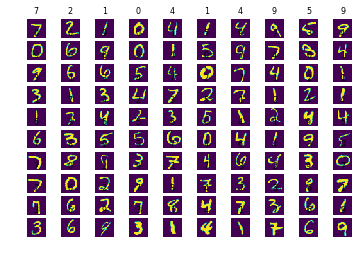

In [34]:
model_path = './models/0/model.h5'
score = model.pred(ML.test_imgs, model_path)
score = np.argmax(score , axis = 1)
sqz_test_imgs=list(np.squeeze(ML.test_imgs))
plot_images(sqz_test_imgs[:100] , list(score[:100]))